In [122]:
import os, sys, wave, struct

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import IPython

from copy import deepcopy
from math import ceil, exp, atan, pi, cos, sin
from scipy.io.wavfile import write
#import scipy.io.wavfile
from scipy.linalg import hankel
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

import pylab as p
#import matplotlib.axes3d as p3
import mpl_toolkits.mplot3d.axes3d as p3

# Useful functions

In [123]:
def load_sound(file):
    return wave.open(file, 'rb')

def plot_sound(data, times,xlim1,xlim2,name='default_name', save=False,w=20,h=10, lw = 3):
    plt.figure(figsize=(w, h))
    plt.plot(times,x.reshape(len_x))
    plt.xlim(xlim1,xlim2)
    plt.xlabel('time (s)')
    plt.ylabel('amplitude')
    if save:
        plt.savefig(name+'.png', dpi=100)
    plt.show()
    
def read_values(filename):
    wave_file = wave.open(filename, 'r')
    nframes = wave_file.getnframes()
    nchannels = wave_file.getnchannels()
    sampling_frequency = wave_file.getframerate()
    T = nframes / float(sampling_frequency)
    read_frames = wave_file.readframes(nframes)
    wave_file.close()
    data = struct.unpack("%dh" %  nchannels*nframes, read_frames)
    
    data_per_channel = [data[offset::nchannels] for offset in range(nchannels)]
    return T, np.array(data_per_channel), nframes, nchannels, sampling_frequency

In [124]:
def Synthesis(N,delta,f,a,phi,RSB=False):
    t = range(N)
    logz = delta + 1j*2*np.pi*f
    alpha = a*np.exp(1j*phi)
    x = np.sum(np.outer(alpha, np.ones(N))*np.exp(np.outer(logz,t)), axis=0)
    if RSB == False: 
        s = x
    else: 
        Ex = np.real(np.sum(np.abs(x)**2))/N
        b = np.random.normal(size=N) + 1j*np.random.normal(size=N)
        Eb = np.real(np.sum(np.abs(b)**2))/N
        b = b*np.sqrt(Ex/Eb)*10**(-RSB/20)
        s = x+b    
    return s

# Open audio file

In [125]:
wavefile = load_sound('ClocheB.WAV')
print(wavefile.getparams())

_wave_params(nchannels=1, sampwidth=2, framerate=8000, nframes=99414, comptype='NONE', compname='not compressed')


In [126]:
IPython.display.Audio('ClocheB.WAV')

In [127]:
T, data, nframes, nchannels, sampling_frequency = read_values('ClocheA.WAV')
Fs = int(wavefile.getframerate())
x = np.array(data)
num_samples = int(wavefile.getnframes())

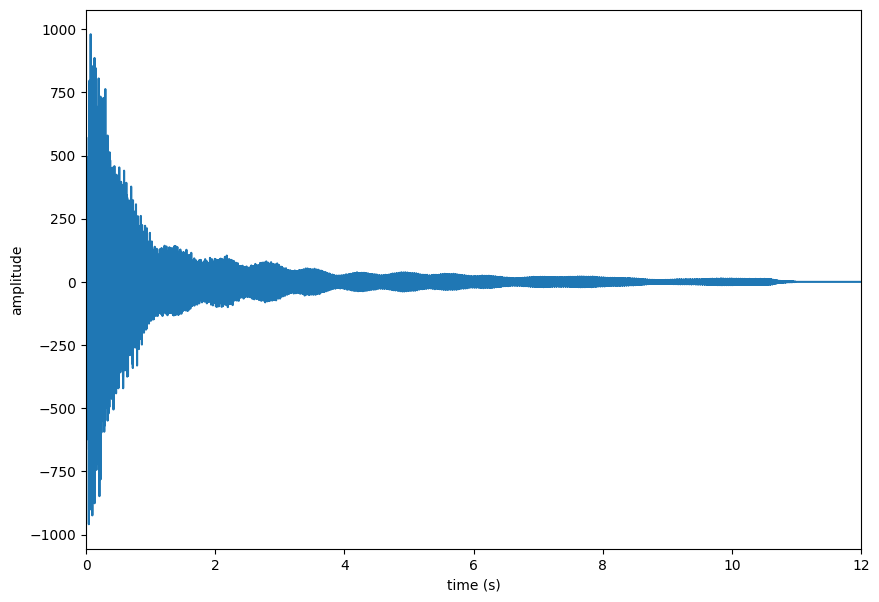

In [128]:
len_x = x.shape[1]
timestep = 1/(float(Fs))
times = np.arange(len_x)*timestep # int(len_x/6)
plot_sound(x.reshape(len_x), times,0,12,w=10,h=7)

In [129]:
write('new_bell.wav', Fs, np.array(x.reshape(len_x), dtype=np.int16)) # to write a new wave file

### 3.1 Spectral Analysis

[0.25       0.26587302]
[ 1 10]
[ 0.   -0.05]
[-3.07758062 -0.27174025]


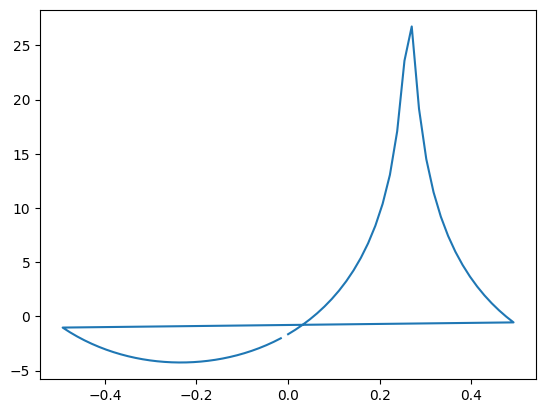

In [130]:

N=63
f0=0.25
f1=f0+1/N

f=np.array([f0,f1])
a=np.array([1,10])
delta=np.array([0,-0.05])
phi=np.random.uniform(-np.pi,np.pi,2)
print(f)
print(a)
print(delta)
print(phi)
y=Synthesis(N,delta,f,a,phi)
N_FFT=N
dft= np.fft.fft(y,N_FFT)
S_hat=(np.absolute(dft)**2)/N

S_hat_dB=10*np.log10(S_hat)

nu=np.fft.fftfreq(N_FFT)
plt.plot(nu,S_hat_dB)


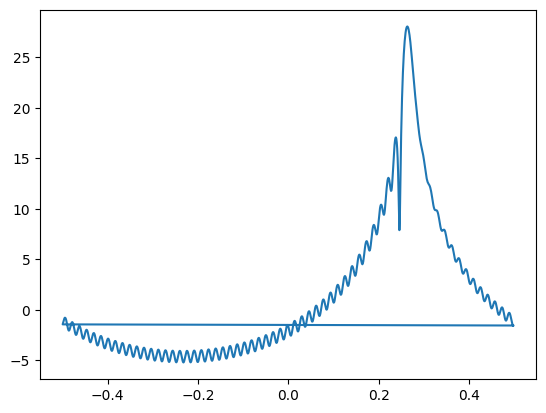

In [131]:
N_FFT=1024
dft= np.fft.fft(y,N_FFT)
S_hat=(np.absolute(dft)**2)/N
nu=np.fft.fftfreq(N_FFT)
plt.plot(nu,10*np.log10(S_hat))

We observe one peak instead of two peaks in both cases.However the periodogram with zero padding is slightly better

### 3.2 High resolution methods:

#### 1. Computation of the empirical covariance matrix:

In [132]:
def computeEmpCovMatrix(x,n):
    N=len(x)
    l=N+1-n
    r=np.array([x[n-1+i] for i in range(0,l)])
    X=hankel(x[0:n],r=r)
    X_h=np.conjugate(X.T)
    Rxx_hat=(1/l)*X@X_h
    
    return Rxx_hat

#### 2.Estimation of the signal subspace:

In [133]:
def estimateSignalSubspace(Rxx_hat,K):
    [U1,Lambda,U2]=np.linalg.svd(Rxx_hat)
    
   
    W=np.array([U1[:,j]for j in range(K)]).T
    
    return W



#### 3.2.1 ESPRIT method:

##### 3. Estimation of the frequencies and damping factors:

In [134]:
def estimateFreqDampingFactors(W):
    W_down=W[:-1,:]
    W_up=W[1:,:]
    phi=np.linalg.pinv(W_down)@W_up
    eigvalues,eigvectors=np.linalg.eig(phi)
    
    delta=np.log(np.absolute(eigvalues))
    
    f=(np.angle(eigvalues)/(2*np.pi))
    return [delta,f]
    

##### 4. Estimation of the amplitudes and phases:

In [135]:
def LeastSquares(x,delta,f):
    N=len(x)
    j=complex(0,1)
    temp=delta+j*2*np.pi*f
    
    V_N=np.exp(np.array(list(range(N))).reshape(-1,1)@temp.reshape(1,-1))
    alpha=np.linalg.pinv(V_N)@x
    a=np.absolute(alpha)
    phi=np.angle(alpha)
    return [a,phi]

#### 5.Application to synthetic signals

In [136]:
def ESPRIT(x,n,K):
    Rxx_hat=computeEmpCovMatrix(x,n)
    W=estimateSignalSubspace(Rxx_hat,K)
    [delta,f]=estimateFreqDampingFactors(W)
    
    return [delta,f]



In [144]:
n=32
K=2
[delta,f]=ESPRIT(y,n,K)
[a,phi]=LeastSquares(y,delta,f)
print(f)
print(delta)
print(a)
print(phi)

[0.26587302 0.25      ]
[-5.00000000e-02  2.22044605e-16]
[10.  1.]
[-0.27174025 -3.07758062]


We observe that the frequencies ,the damping factors, the amplitudes and the phases estimated are exactly the same but are ordered in decreased order because in our algorithm the eigenvalues of matrix $\Lambda$ were sorted in decreasing order.

#### 3.2.2 MUSIC method

In [138]:
def MUSIC(x,n,K):
    f=np.linspace(0, 1, 100)
    delta=np.linspace(-0.1, 0.1, 100)
    z=np.zeros((len(f),len(delta)), dtype=complex)
    j=complex(0,1)
    for p in range(len(f)):
        for q in range(len(delta)):
            z[p][q]=np.exp(delta[q]+j*2*np.pi*f[p])
    Rxx_hat=computeEmpCovMatrix(x,n)
    [U1,Lambda,U2]=np.linalg.svd(Rxx_hat)
    
    
    W=U1[:,K:]
    P=np.zeros((len(f),len(delta)))

    for p in range(len(f)):
        for q in range(len(delta)):
            v_n=np.array([z[p][q]**s for s in range(n)])
            P[p][q]=1/np.linalg.norm(np.conjugate(W.T)@v_n)**2 
    fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
    f, delta = np.meshgrid(f, delta)
    # Plot the surface.
    surf = ax.plot_surface(f, delta, np.log(P), cmap=cm.coolwarm,
                        linewidth=0, antialiased=False)

    # Customize the z axis.
    
    ax.zaxis.set_major_locator(LinearLocator(10))
    # A StrMethodFormatter is used automatically
    ax.zaxis.set_major_formatter('{x:.02f}')

    # Add a color bar which maps values to colors.
    fig.colorbar(surf, shrink=0.5, aspect=5)
    plt.xlabel('frequency')
    plt.ylabel('delta')


    plt.show()

    
    

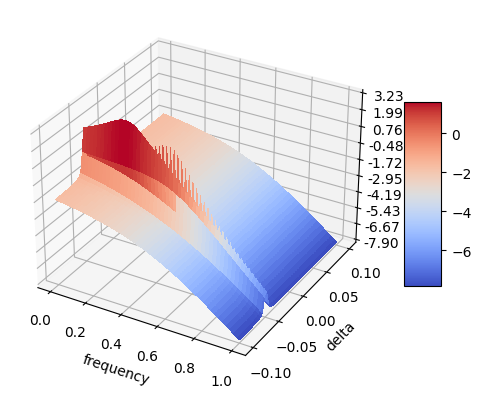

In [139]:
n=32
K=2
MUSIC(y,n,K)


We observe clearly that there are now two peaks highlighted around frequency 0.25 with two different damping factors 0 and -0.05.

#### 4.Audio signals

##### 4.1 Spectral Analysis by Fourier Transform:

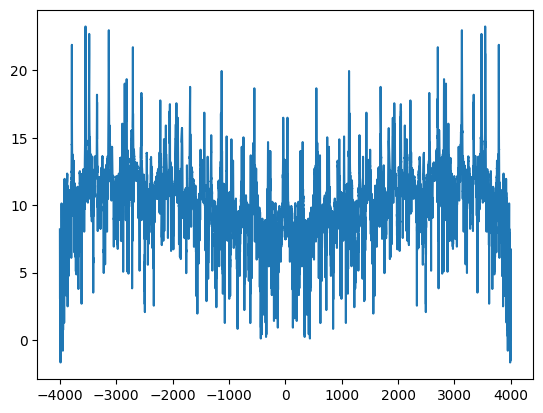

In [140]:

x=x.reshape(-1)
dft= np.fft.fft(x)
S_hat=(np.absolute(dft)**2)/N
nu=np.linspace(-0.5,0.5,x.shape[0])
freq=np.linspace(-Fs/2,Fs/2,x.shape[0])
logPeriodo=np.log(S_hat.T)
plt.plot(freq,logPeriodo)

We observe for exemple that there is a factor of 1.2 between the second and the third peak in frequency.
Between the second and the fourth, there is a factor of 1.5 in frequency and so on.
The sequence of eigenfrequencies is verified. 

##### 4.2 High resolution methods:

In [141]:
K=54
n=512
l=1024
N=1535
x_delayed=x[10000:10000+N+1]
[delta,f]=ESPRIT(x,n,K)
[a,phi]=LeastSquares(x,delta,f)
print(f)
print(delta)
print(a)


[ 0.4953645  -0.4953645   0.43121592 -0.43121592  0.35873724 -0.35873724
  0.35721459 -0.35721459  0.3202017  -0.3202017   0.28868811 -0.28868811
  0.27069819 -0.27069819  0.26003468 -0.26003468  0.25823129 -0.25823129
  0.24381662 -0.24381662  0.23479275 -0.23479275  0.22264098 -0.22264098
  0.18068354 -0.18068354  0.16187674 -0.16187674  0.15890199 -0.15890199
  0.14807239 -0.14807239  0.14696647 -0.14696647  0.14376634 -0.14376634
  0.10845555 -0.10845555  0.10859471 -0.10859471  0.11207009 -0.11207009
  0.02657258 -0.02657258  0.08228622 -0.08228622  0.0568219  -0.0568219
  0.05697829 -0.05697829  0.06492468 -0.06492468  0.06515906 -0.06515906]
[-3.94626184e-04 -3.94626184e-04 -2.11752071e-04 -2.11752071e-04
 -9.38271251e-05 -9.38271251e-05 -3.19593672e-03 -3.19593672e-03
 -2.69790838e-04 -2.69790838e-04 -2.28321066e-04 -2.28321066e-04
 -1.32918260e-03 -1.32918260e-03 -2.09554755e-03 -2.09554755e-03
 -4.09655578e-04 -4.09655578e-04 -1.04139472e-04 -1.04139472e-04
 -6.25003201e-04 -

In [142]:
x_synth=Synthesis(50000,delta,f,a,phi)

write('new_bell.wav', Fs, np.array(x_synth.reshape(50000), dtype=np.int16)) # to write a new wave file

C:\Users\Dell\AppData\Local\Temp\ipykernel_4292\2310630451.py:3: ComplexWarning: Casting complex values to real discards the imaginary part
  write('new_bell.wav', Fs, np.array(x_synth.reshape(50000), dtype=np.int16)) # to write a new wave file


After resynthesizing the signal, we clearly hear a bell sound which is really similar to the sound of ClocheA